# Project 1 in course 02463

## Implementing Bayesian optimization for a CNN as a means to find optimal hyperparameters

### The code for the CNN was heavily inspired by the following kaggle article:
#### https://www.kaggle.com/mirhyun0508/2022-smarcle-ai-fashion-mnist-cnn



### Import dependencies

In [55]:
import sys
import os

import keras
from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential

import GPyOpt

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer

In [56]:
train = pd.read_csv('Data/fashion-mnist_train.csv')
test = pd.read_csv('Data/fashion-mnist_test.csv')

class_names = train.columns

In [57]:
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB


In [58]:
X_train = train.drop(["label"], axis=1)
Y_train = train["label"]

X_test = test.drop(["label"], axis=1)
Y_test = test["label"]

X_train = X_train.to_numpy()
Y_train = Y_train.to_numpy()

X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255

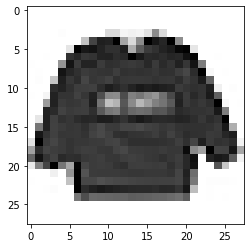

In [59]:
# Display an image
plt.imshow(X_train[0], cmap='Greys')
plt.show()

In [60]:
Y_train = np_utils.to_categorical(Y_train)
Y_test = np_utils.to_categorical(Y_test)

### Defining CNN class

In [79]:
class CNN:
    def __init__(self, X_train, Y_train, X_test, Y_test):
        #self.n_epochs = n_epochs
        #self.kernel_size = kernel_size
        #self.learning_rate = learning_rate
        #self.batch_size = batch_size
        
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        
        
        
    def CNNModelTrain(self, n_epochs, batch_size, kernel_size, learning_rate, summary = False):
        
        # The model is created
        model = Sequential()
        model.add(Conv2D(32, kernel_size=(kernel_size, kernel_size) , input_shape = (28, 28, 1), activation='relu'))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(10, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = learning_rate), metrics=['accuracy'])
        
        # Display model summary if true
        if summary == True:
            model.summary()
        
        # Train the model
        #MODEL_DIR = './model/'
        #if not os.path.exists(MODEL_DIR):
        #  os.mkdir(MODEL_DIR)

        #modelpath='./model/{epoch:02d}-{val_loss:.4f}.hdf5'
        #checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
        #early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
        
        history = model.fit(X_train, Y_train, 
        validation_data=(X_test, Y_test), epochs=n_epochs, 
        batch_size= batch_size, verbose=1)
        #callbacks=[early_stopping_callback, checkpointer])
        
        accuracies = history.history['val_accuracy']
        return history, accuracies[-1]
    
    
    def plotResults(self, history):
        y_vacc = history.history['val_accuracy']

        y_acc = history.history['accuracy']


        x_len = np.arange(1,len(y_acc)+1, 1)
        plt.plot(x_len, y_vacc, marker='.', c='red', label='Testset_accuracy')
        plt.plot(x_len, y_acc, marker='.', c='blue', label='Trainset_accuracy')


        plt.legend(loc='upper right')
        plt.grid()
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.show()
    
        
        

### Create a model and train with fixed hyperparameters (deliberately bad)
#### The train-test dynamics are illustrated
##### Train and test accuracy is also visualized below

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 11, 11, 64)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 11, 11, 64)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 7744)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               991360    
_________________________________________________________________
dropout_41 (Dropout)         (None, 128)             

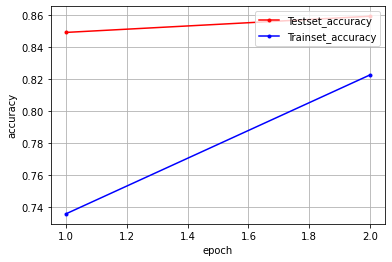

Accuracy at the last epoch: 0.8590999841690063
Loss at the last epoch: 0.37954336404800415


In [80]:
# If you want the model to perform well set lr = 0.001 and k = 3.

# Keep these values fixed if you want a decent but improvable result:
## e = 5, lr = 0.05, k = 5, b = 400
e = 2
lr = 0.03
k = 5
b = 400


m = CNN(X_train = X_train, Y_train = Y_train, X_test = X_test,Y_test = Y_test)
# Create a CNN model
hist, final_acc = m.CNNModelTrain(n_epochs = e, batch_size = b, kernel_size = k, learning_rate = lr,summary = True)


m.plotResults(hist)


final_loss = hist.history['val_loss'][-1]
print("Accuracy at the last epoch:", final_acc)
print("Loss at the last epoch:", final_loss)

## Implementing Exhaustive Search for finding the optimal hyperparameters

### Hyperparameters are defined:

In [110]:
# Learning rate:
lr = tuple(np.arange(0.001, 0.15, 0.05, dtype = np.float64))
# Number of epochs
n_epochs = tuple(np.arange(2, 12, 2, dtype = np.int64))
# Kernel sizes
kernel_sizes = tuple(np.arange(1,7,2, dtype = np.int64))
# batch sizes
batch_sizes = tuple(np.arange(100,500, 100, dtype = np.int64))
print(lr)
print(n_epochs)
print(kernel_sizes)


for l in lr:
    print(l)

(0.001, 0.051000000000000004, 0.101)
(2, 4, 6, 8, 10)
(1, 3, 5)
0.001
0.051000000000000004
0.101


In [ ]:
# Record the time taken until convergence
start = timer()

final_losses = list()
final_accs = list()

optimal_hyperparams = [0,0,0,0]
best_acc = 0


for e in n_epochs:
    for b in batch_sizes:
        for k in kernel_sizes:
            for l in lr:
                m = CNN(X_train = X_train, Y_train = Y_train, X_test = X_test,Y_test = Y_test)
                
                # Create CNN model and train it
                hist, acc = m.CNNModelTrain(n_epochs = e, batch_size = b, 
                                        kernel_size = k, learning_rate = l, summary = False)
                
                final_losses.append(hist.history['val_loss'][-1])
                final_accs.append(acc)

                if max(final_accs) > best_acc:
                    best_acc = max(final_accs)
                    optimal_hyperparams = [e, b, k, l]

end = timer()
print("The best accuracy was:", max(final_accs))
print("-------------------------------------------")
print("The best hyperparameters were found to be:")
print("Number of epochs:", optimal_hyperparams[0])
print("Batch size:", optimal_hyperparams[1])
print("Kernel size:", optimal_hyperparams[2])
print("Learning rate:", optimal_hyperparams[3])

print("It took", end-start, "time until convergence")


Epoch 1/2
210/600 [=========>....................] - ETA: 1:01 - loss: 0.6470 - accuracy: 0.7725

In [ ]:
def CNN_Model_Train( kernel_size, learning_rate, n_epochs = 5,batch_size = 300):
    
    # The model is created
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(int(kernel_size), int(kernel_size)) , input_shape = (28, 28, 1), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = learning_rate), metrics=['accuracy'])
    
    
    # Train the model
    MODEL_DIR = './model/'
    if not os.path.exists(MODEL_DIR):
        os.mkdir(MODEL_DIR)

    modelpath='./model/{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(X_train, Y_train, 
    validation_data=(X_test, Y_test), epochs=n_epochs, 
    batch_size= batch_size, verbose=1, 
    callbacks=[early_stopping_callback, checkpointer])

    accuracies = history.history['val_accuracy']
    return accuracies[-1]

## Bayesian optimization using GpyOpt

#### This code is inspired by code from Exercise 4 in course 02463

In [109]:
start = timer()

# Same hyperparameters as before:
## Learning rate:
lr = tuple(np.arange(0.001, 0.15, 0.05, dtype = np.float64))
## Number of epochs
n_epochs = tuple(np.arange(2, 12, 2, dtype = np.int64))
## Kernel sizes
kernel_sizes = tuple(np.arange(1,8,2, dtype = np.int64))
## batch sizes
batch_sizes = tuple(np.arange(100,500, 100, dtype = np.int64))


domain = [{'name': 'kernel_sizes', 'type': 'discrete', 'domain': kernel_sizes},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': lr},
          {'name': 'n_epochs', 'type': 'discrete', 'domain': n_epochs},
          {'name': 'batch_sizes', 'type': 'discrete', 'domain': batch_sizes}
          ]

def objective_function(x):
    param = x[0]
    
    acc = CNN_Model_Train(kernel_size = param[0], learning_rate = param[1])
    
    return -float(acc)


### EI acquisition function ###
acquisition_func = "EI"

opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = acquisition_func      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=.1

opt.run_optimization(max_iter = 10) 

x_best = opt.X[np.argmin(opt.Y)]

end = timer()
print("For acquisition_type: {0}".format(acquisition_func))
print("time: {0}".format(end - start))
print("The best parameters obtained: {0}".format(x_best))
print("The accuracy was: {0}".format(-min(opt.Y)))

Epoch 1/5
200/200 [==============================] - ETA: 0s - loss: 3.3790 - accuracy: 0.5275
Epoch 00001: val_loss improved from inf to 0.75483, saving model to ./model\01-0.7548.hdf5
200/200 [==============================] - 52s 259ms/step - loss: 3.3790 - accuracy: 0.5275 - val_loss: 0.7548 - val_accuracy: 0.6977
Epoch 2/5
200/200 [==============================] - ETA: 0s - loss: 0.8986 - accuracy: 0.6627
Epoch 00002: val_loss improved from 0.75483 to 0.70344, saving model to ./model\02-0.7034.hdf5
200/200 [==============================] - 52s 259ms/step - loss: 0.8986 - accuracy: 0.6627 - val_loss: 0.7034 - val_accuracy: 0.7258
Epoch 3/5
200/200 [==============================] - ETA: 0s - loss: 0.8875 - accuracy: 0.6693
Epoch 00003: val_loss improved from 0.70344 to 0.62697, saving model to ./model\03-0.6270.hdf5
200/200 [==============================] - 52s 259ms/step - loss: 0.8875 - accuracy: 0.6693 - val_loss: 0.6270 - val_accuracy: 0.7545
Epoch 4/5
200/200 [=============

KeyboardInterrupt: 

In [ ]:
### MPI acquisition function ###
acquisition_func = "MPI"

opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = acquisition_func      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=.1

opt.run_optimization(max_iter = 10) 

x_best = opt.X[np.argmin(opt.Y)]

end = timer()
print("For acquisition_type: {0}".format(acquisition_func))
print("time: {0}".format(end - start))
print("The best parameters obtained: {0}".format(x_best))
print("The loss was: {0}".format(min(opt.Y)))








### MPI acquisition function ###
acquisition_func = "LCB"

opt = GPyOpt.methods.BayesianOptimization(f = objective_function,   # function to optimize
                                              domain = domain,         # box-constrains of the problem
                                              acquisition_type = acquisition_func      # Select acquisition function MPI, EI, LCB
                                             )
opt.acquisition.exploration_weight=.1

opt.run_optimization(max_iter = 10) 

x_best = opt.X[np.argmin(opt.Y)]

end = timer()
print("For acquisition_type: {0}".format(acquisition_func))
print("time: {0}".format(end - start))
print("The best parameters obtained: {0}".format(x_best))
print("The loss was: {0}".format(min(opt.Y)))